# Results analysis

#### dataset Loading and options 

In [2]:
from datasets import (
    Dataset,
    load_dataset,
    concatenate_datasets,
    get_dataset_config_names,
)
import pandas as pd
import seaborn as sb

all_configs = [
    config_name
    for config_name in get_dataset_config_names("CharlyR/varbench-evaluation")
    if "benchmark" in config_name
]
print(all_configs)
all_datasets: list[Dataset] = []

for config in all_configs:
    conf_ds = load_dataset("CharlyR/varbench-evaluation", config, split="tikz")
    config_name_column = ["".join(config.split("_benchmark"))] * len(conf_ds)
    all_datasets.append(conf_ds.add_column("config", config_name_column))


dataset = concatenate_datasets(all_datasets)

import os

result_path = os.path.join("results", "all_results")
not os.path.exists("results/all_results") and os.mkdir("results/" + "all_results")

['simpleLLM_benchmark_deepseekr1distillllama70b_pk_1_t_0.7', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_0.7', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_1.5', 'simpleLLM_benchmark_llama3.18binstant_pk_1_t_0.7', 'simpleLLM_benchmark_llama3.370bversatile_pk_1_t_0.7', 'simpleLLM_benchmark_llama3.370bversatile_pk_5_t_0.7', 'simpleLLM_benchmark_llama370b8192_pk_1_t_0.7']


Generating tikz split: 100%|██████████| 50/50 [00:00<00:00, 5048.27 examples/s]


False

TODO: UPDATE:

**Are LLMs capable of generating variants of code?**
- RQ: Are LLM capable of generating valid variants ?
- RQ: How  often are the variants the exact reference solution ?
- RQ: Are they capable of modifying the right lines ?
- RQ: Are the performance correlated with the complexity of the edit?

## Variants Overall Validity

In [3]:
df  = dataset.to_pandas()[["config","id","parsing_score","compiling_score"]]

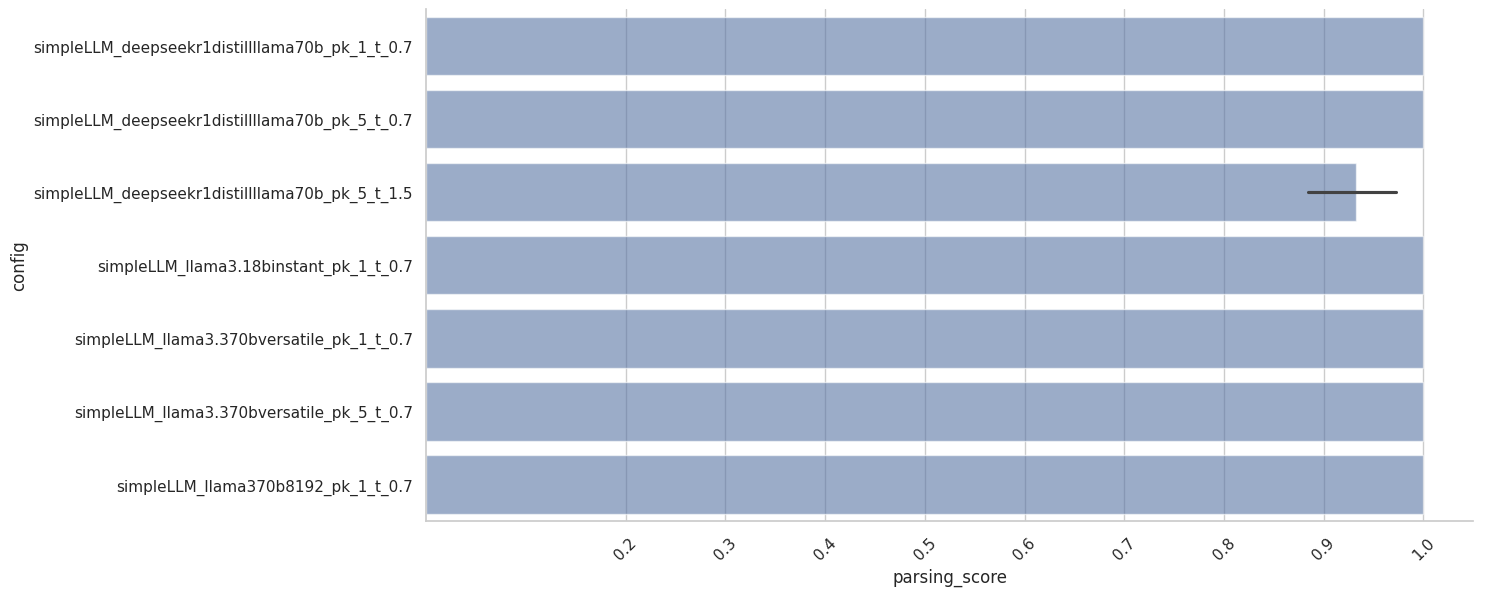

In [4]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="parsing_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["parsing_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

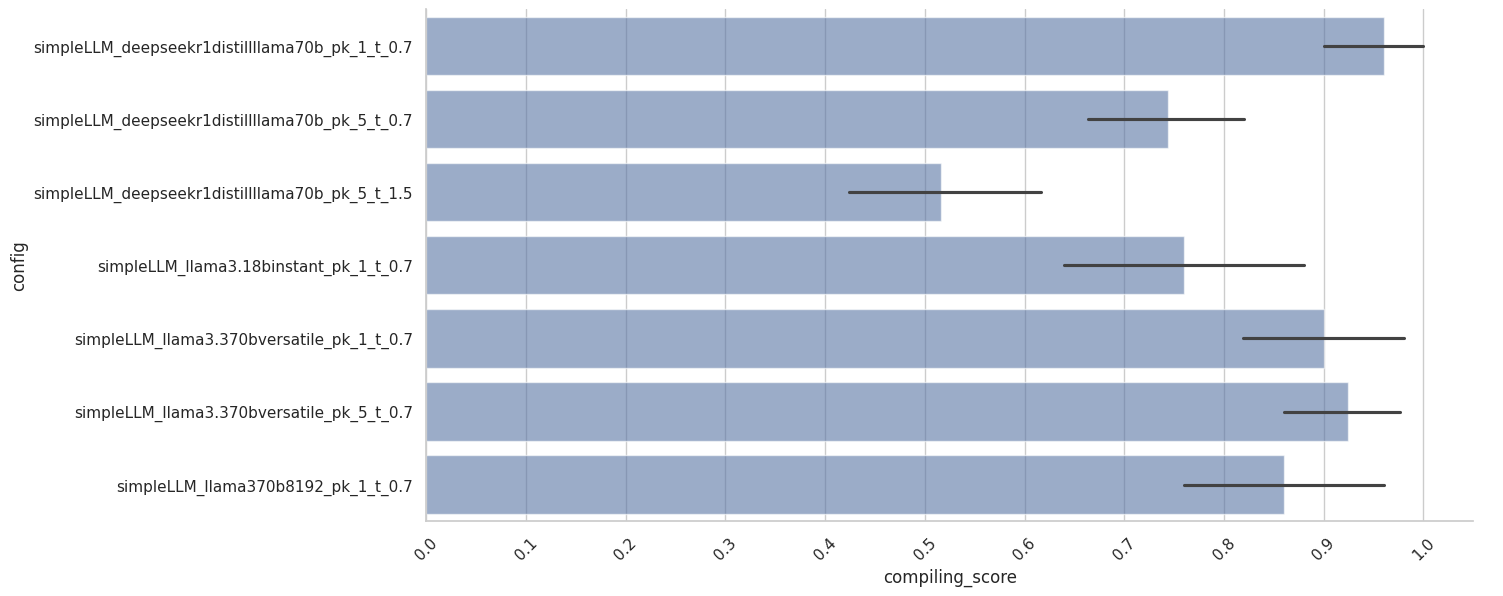

In [5]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="compiling_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["compiling_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

## Best prediction computation

---

In [6]:
from results_utils import MetricPolicy
import pandas as pd

computed_metrics_names = [
    metric_name
    for metric_name in dataset.column_names
    if metric_name.endswith("Metric")
]

# TODO Update with metric_analysis output
most_important_metrics = ["PatchMetric", "LineMetric"]
metric_priority_order = most_important_metrics + (
    list(set(computed_metrics_names) - set(most_important_metrics))
)

print(computed_metrics_names + ["images_result", "predictions", "predictions_patches"])

result_df: pd.DataFrame = dataset.to_pandas().explode(
    computed_metrics_names + ["images_result", "predictions", "predictions_patches"]
)

df_sorted = result_df.sort_values(by=metric_priority_order, ascending=False)

# Get the highest row per group based on sorting order
result = df_sorted.groupby(["id", "config"]).first().reset_index()


result_df = result[computed_metrics_names + ["id", "config","difficulty"]].astype({m_name:'float' for m_name in computed_metrics_names})
result_df

['FeatureMatchMetric', 'TERMetric', 'ChrfPatchMetric', 'BleuPatchMetric', 'MSSSIMMetric', 'LineMetric', 'PSNRMetric', 'TERPatchMetric', 'MSEMetric', 'ClipTextMetric', 'BleuMetric', 'ChrfMetric', 'PatchMetric', 'ClipImageMetric', 'LPIPSMetric', 'CrystalBleuMetric', 'CrystalBleuPatchMetric', 'images_result', 'predictions', 'predictions_patches']


,FeatureMatchMetric,TERMetric,ChrfPatchMetric,BleuPatchMetric,MSSSIMMetric,LineMetric,PSNRMetric,TERPatchMetric,MSEMetric,ClipTextMetric,BleuMetric,ChrfMetric,PatchMetric,ClipImageMetric,LPIPSMetric,CrystalBleuMetric,CrystalBleuPatchMetric,id,config,difficulty
0,NaN,87.062935,43.581493,3.476955,NaN,100.0,NaN,50.000000,NaN,NaN,90.586449,96.195602,0.0,NaN,NaN,87.919968,2.953135,bee_eyes,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,hard
1,70.238098,95.402298,42.864479,3.588251,98.061996,100.0,50.019276,50.000000,99.875160,24.692249,95.766014,97.464722,0.0,99.565025,98.778915,94.019928,2.911465,bee_eyes,simpleLLM_deepseekr1distillllama70b_pk_5_t_0.7,hard
2,60.714287,88.612099,36.828899,3.479769,95.848038,0.0,46.754368,50.000000,99.566216,26.114388,93.302132,96.623741,0.0,99.670990,97.986061,90.567055,2.549375,bee_eyes,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,hard
3,NaN,95.402298,49.053074,7.659487,NaN,100.0,NaN,56.666668,NaN,NaN,95.647079,97.325882,0.0,NaN,NaN,93.571838,6.491458,bee_eyes,simpleLLM_llama3.18binstant_pk_1_t_0.7,hard
4,NaN,93.609024,50.257553,4.708044,NaN,100.0,NaN,50.000000,NaN,NaN,93.854279,97.331070,0.0,NaN,NaN,91.865944,4.262206,bee_eyes,simpleLLM_llama3.370bversatile_pk_1_t_0.7,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,55.000000,99.166664,84.211800,82.060287,90.197067,100.0,35.400593,81.818184,99.658730,26.097666,99.185928,99.128319,0.0,99.696953,97.647720,98.187874,79.008530,squid_yellow,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,easy
346,30.000000,98.347107,69.147514,35.775417,58.434551,100.0,35.396053,50.000000,97.769997,26.920193,98.033318,97.705002,0.0,98.801987,90.102234,95.997307,32.838085,squid_yellow,simpleLLM_llama3.18binstant_pk_1_t_0.7,easy
347,67.500000,99.166664,83.549843,43.596508,97.538361,100.0,47.476196,50.000000,99.971268,26.027548,98.849312,98.706184,0.0,99.746712,98.771393,97.829880,41.562710,squid_yellow,simpleLLM_llama3.370bversatile_pk_1_t_0.7,easy
348,30.000000,98.347107,70.456703,35.775417,87.485191,100.0,35.232479,50.000000,99.612770,26.623367,98.033318,97.791870,0.0,99.619873,97.560806,95.997307,32.838085,squid_yellow,simpleLLM_llama3.370bversatile_pk_5_t_0.7,easy


## Pre-Filtering

In [7]:
# ordering by text metrics IGNORED
""" text_metrics = [
    metric_name
    for metric_name in computed_metrics_names
    if any((substring in metric_name) for substring in ["TER", "Line", "Bleu", "Chrf","Patch"])
]
other_metrics = list(set(computed_metrics_names) - set(text_metrics))
ordered_metrics = [metric for metric in (text_metrics + other_metrics)]
print(text_metrics + other_metrics) """
#Ordering by priority metrics
filtered_df = result_df[metric_priority_order+ ["id", "config","difficulty"]]

In [8]:
filtered_df[filtered_df.isnull().any(axis=1)]

,PatchMetric,LineMetric,TERPatchMetric,BleuMetric,PSNRMetric,BleuPatchMetric,LPIPSMetric,ClipTextMetric,MSEMetric,ClipImageMetric,FeatureMatchMetric,MSSSIMMetric,ChrfPatchMetric,ChrfMetric,CrystalBleuPatchMetric,TERMetric,CrystalBleuMetric,id,config,difficulty
0,0.0,100.000000,50.000000,90.586449,NaN,3.476955,NaN,NaN,NaN,NaN,NaN,NaN,43.581493,96.195602,2.953135,87.062935,87.919968,bee_eyes,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,hard
3,0.0,100.000000,56.666668,95.647079,NaN,7.659487,NaN,NaN,NaN,NaN,NaN,NaN,49.053074,97.325882,6.491458,95.402298,93.571838,bee_eyes,simpleLLM_llama3.18binstant_pk_1_t_0.7,hard
4,0.0,100.000000,50.000000,93.854279,NaN,4.708044,NaN,NaN,NaN,NaN,NaN,NaN,50.257553,97.331070,4.262206,93.609024,91.865944,bee_eyes,simpleLLM_llama3.370bversatile_pk_1_t_0.7,hard
6,0.0,0.000000,56.666668,96.374313,NaN,5.431949,NaN,NaN,NaN,NaN,NaN,NaN,41.916721,97.216331,3.847877,95.769234,94.523972,bee_eyes,simpleLLM_llama370b8192_pk_1_t_0.7,hard
16,0.0,0.000000,56.250000,98.523346,NaN,0.045278,NaN,NaN,NaN,NaN,NaN,NaN,4.976337,99.603226,0.043739,99.163177,97.710632,bee_mirrored,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,easy
32,0.0,100.000000,78.431374,97.882851,NaN,70.483711,NaN,NaN,NaN,NaN,NaN,NaN,91.089577,98.905998,72.592438,96.774193,97.247314,bee_three_wings,simpleLLM_llama3.370bversatile_pk_1_t_0.7,medium
93,0.0,0.000000,50.000000,1.250322,NaN,1.059868,NaN,NaN,NaN,NaN,NaN,NaN,16.716843,21.923363,1.120407,53.005463,1.226079,chimpanzee_shoulder_torso,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,hard
94,0.0,0.000000,53.191490,91.038689,NaN,2.018780,NaN,NaN,NaN,NaN,NaN,NaN,18.673082,93.635025,2.076645,87.782806,89.939148,chimpanzee_shoulder_torso,simpleLLM_llama3.18binstant_pk_1_t_0.7,hard
105,0.0,66.666664,50.000000,91.198792,NaN,26.898645,NaN,NaN,NaN,NaN,NaN,NaN,62.968231,92.786057,26.196075,87.804878,85.162247,cow_brown_white_dots,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,hard
107,0.0,66.666664,50.000000,88.791405,NaN,19.664062,NaN,NaN,NaN,NaN,NaN,NaN,54.023521,90.137398,19.206936,85.039368,80.948120,cow_brown_white_dots,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,hard


## Passing rate

In [9]:
def compute_pass(row):
    row["pass"] = (not row.isnull().any())*100
    return row
pass_dataset = filtered_df[computed_metrics_names+["difficulty","id","config"]].apply(compute_pass,axis=1)


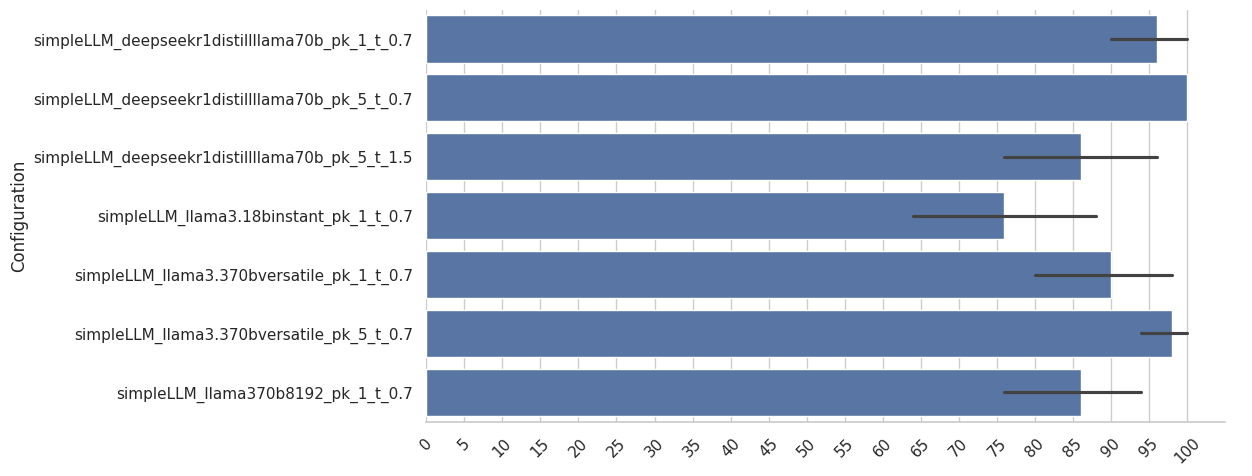

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=pass_dataset, kind="bar", x="pass",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(0, 100.01, step=5))  # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Configuration")
g.legend.set_title("")
plt.savefig(os.path.join(result_path,"pass_rate.png"), dpi=300, bbox_inches="tight")

plt.show()



## Exact patch

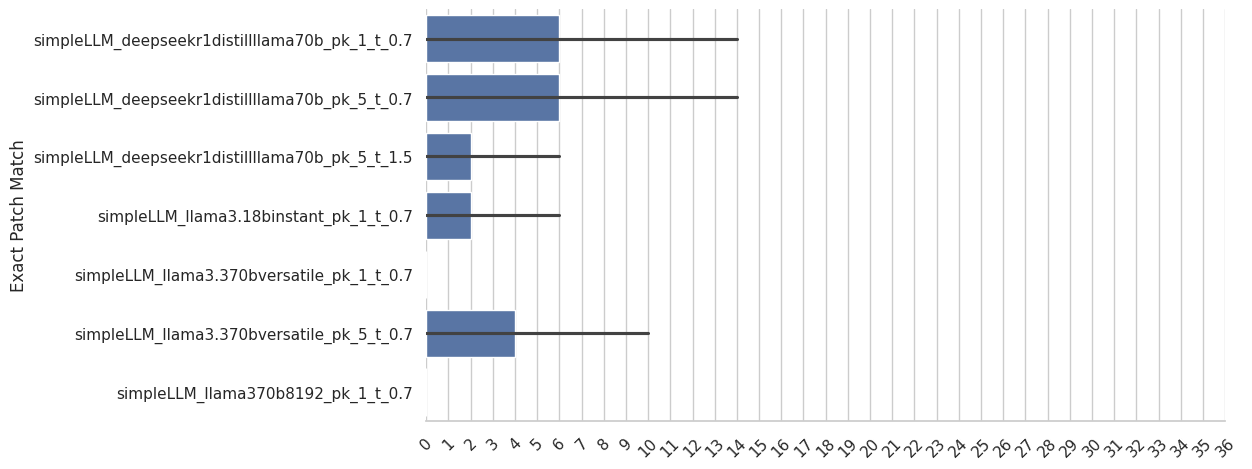

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="PatchMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["PatchMetric"].mean()+filtered_df["PatchMetric"].std()*2, 1)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Exact Patch Match")
g.legend.set_title("")
plt.savefig(os.path.join(result_path,"same_patch_measures.png"), dpi=300, bbox_inches="tight")

plt.show()


## Right lines

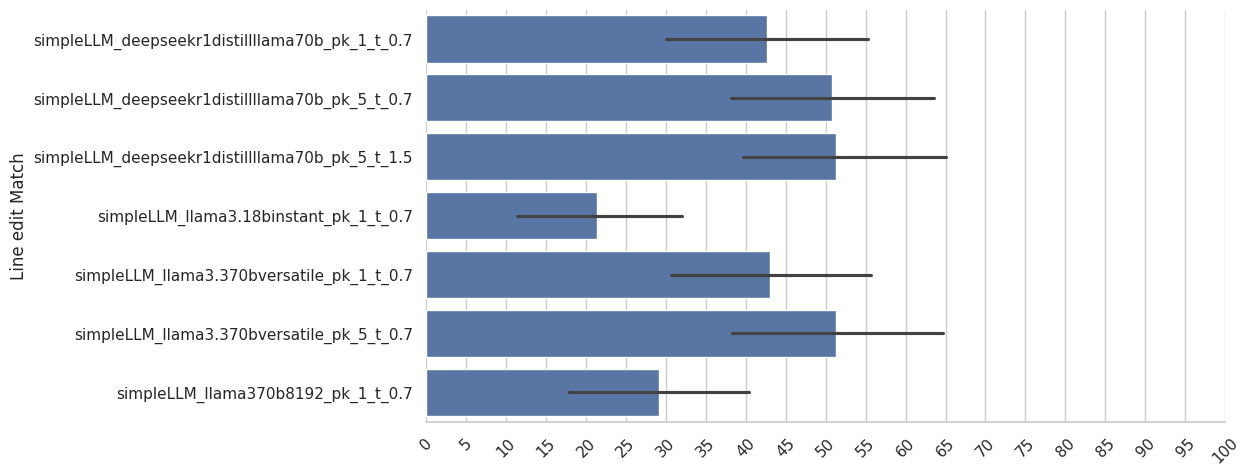

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="LineMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["LineMetric"].max()+1, 5)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Line edit Match")
g.legend.set_title("")

plt.savefig(os.path.join(result_path,"irght_lines_measures.png"), dpi=300, bbox_inches="tight")
plt.show()


## variant classification

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd

def plot_nested_circles_subplot(classed_dataset: pd.DataFrame):
    """
    Generates subplots of nested circle diagrams for each configuration in the dataset.
    Uses a blue gradient color scheme and places values slightly below the top of each circle.
    Only one shared legend is created for the entire plot.
    """
    sns.set()
    
    configs = classed_dataset["config"].unique()
    num_configs = len(configs)
    
    # Calculate the number of rows needed, with a maximum of 3 subplots per row
    ncols = 3
    nrows = (num_configs + ncols - 1) // ncols  # This ensures enough rows
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten()  # Flatten to easily iterate over

    legend_handles = []  # Collect all legend handles here
    
    for i, config in enumerate(configs):
        ax = axes[i]
        ax.set_aspect('equal')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

        cols = classed_dataset.columns.to_list()
        cols.remove("config")
        classes = classed_dataset[classed_dataset["config"] == config][cols].iloc[0].to_dict()
        
        max_r = max(classes.values())
        ax.set_xlim(-max_r - 1, max_r + 1)
        ax.set_ylim(-1, max_r * 2 + 1)

        n = len(classes)
        cmap = LinearSegmentedColormap.from_list('blue_gradient', ['#ADD8E6', '#00008B'], N=n)
        colors = [cmap(i) for i in np.linspace(0, 1, n)]

        sorted_classes = sorted(classes.items(), key=lambda x: x[1], reverse=True)

        for (label, r), color in zip(sorted_classes, colors):
            circle = plt.Circle((0, r), r, fill=True, facecolor=color, alpha=0.6,
                                edgecolor='black', linewidth=2)
            ax.add_patch(circle)

            # Collect the legend handles (only once for each unique color)
            if i == 0:  # Only create the legend once, for the first plot
                legend_handles.append(mpatches.Patch(color=color, label=f"{label} ({r})"))

            # Adjust text position
            ax.annotate(str(r),(0,r*2),(0,-1),ha='center', va='bottom', fontsize=12,textcoords='offset points')

        ax.set_title(f"{config}", y=1.05)

    # Hide unused subplots
    for j in range(num_configs, len(axes)):
        axes[j].axis('off')

    # Create one shared legend for the entire plot
    fig.legend(handles=legend_handles, loc='lower right', bbox_to_anchor=(1, 0), frameon=False)

    plt.tight_layout()
    plt.savefig(os.path.join(result_path, "concentric_variant_classif.png"), dpi=300, bbox_inches="tight")
    plt.show()


In [14]:
def compute_class(row):
    row["total"] = 1
    row["valid"] = not row.isnull().any()
    row["correct"] = row["ChrfPatchMetric"] > 50 and row["valid"] # arbitrary for now
    row["sound"] = row["LineMetric"] > 0 and row["correct"] 
    row["perfect"] = row["PatchMetric"] == 100 and row["sound"]
    return row


classed_dataset = filtered_df[
    computed_metrics_names + ["difficulty", "id", "config"]
].apply(compute_class, axis=1)[["difficulty", "id", "config","total","valid","correct","sound","perfect"]]
classed_dataset =classed_dataset.groupby("config").sum().reset_index()
classed_dataset

,config,difficulty,id,total,valid,correct,sound,perfect
0,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,hardmediumeasyeasymediummediumeasyeasyhardmedi...,bee_eyesbee_longer_bodybee_mirroredbee_red_str...,50,48,19,16,3
1,simpleLLM_deepseekr1distillllama70b_pk_5_t_0.7,hardmediumeasyeasymediummediumeasyeasyhardmedi...,bee_eyesbee_longer_bodybee_mirroredbee_red_str...,50,50,22,21,3
2,simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,hardmediumeasyeasymediummediumeasyeasyhardmedi...,bee_eyesbee_longer_bodybee_mirroredbee_red_str...,50,43,22,19,1
3,simpleLLM_llama3.18binstant_pk_1_t_0.7,hardmediumeasyeasymediummediumeasyeasyhardmedi...,bee_eyesbee_longer_bodybee_mirroredbee_red_str...,50,38,5,4,1
4,simpleLLM_llama3.370bversatile_pk_1_t_0.7,hardmediumeasyeasymediummediumeasyeasyhardmedi...,bee_eyesbee_longer_bodybee_mirroredbee_red_str...,50,45,17,13,0
5,simpleLLM_llama3.370bversatile_pk_5_t_0.7,hardmediumeasyeasymediummediumeasyeasyhardmedi...,bee_eyesbee_longer_bodybee_mirroredbee_red_str...,50,49,25,22,2
6,simpleLLM_llama370b8192_pk_1_t_0.7,hardmediumeasyeasymediummediumeasyeasyhardmedi...,bee_eyesbee_longer_bodybee_mirroredbee_red_str...,50,43,13,11,0


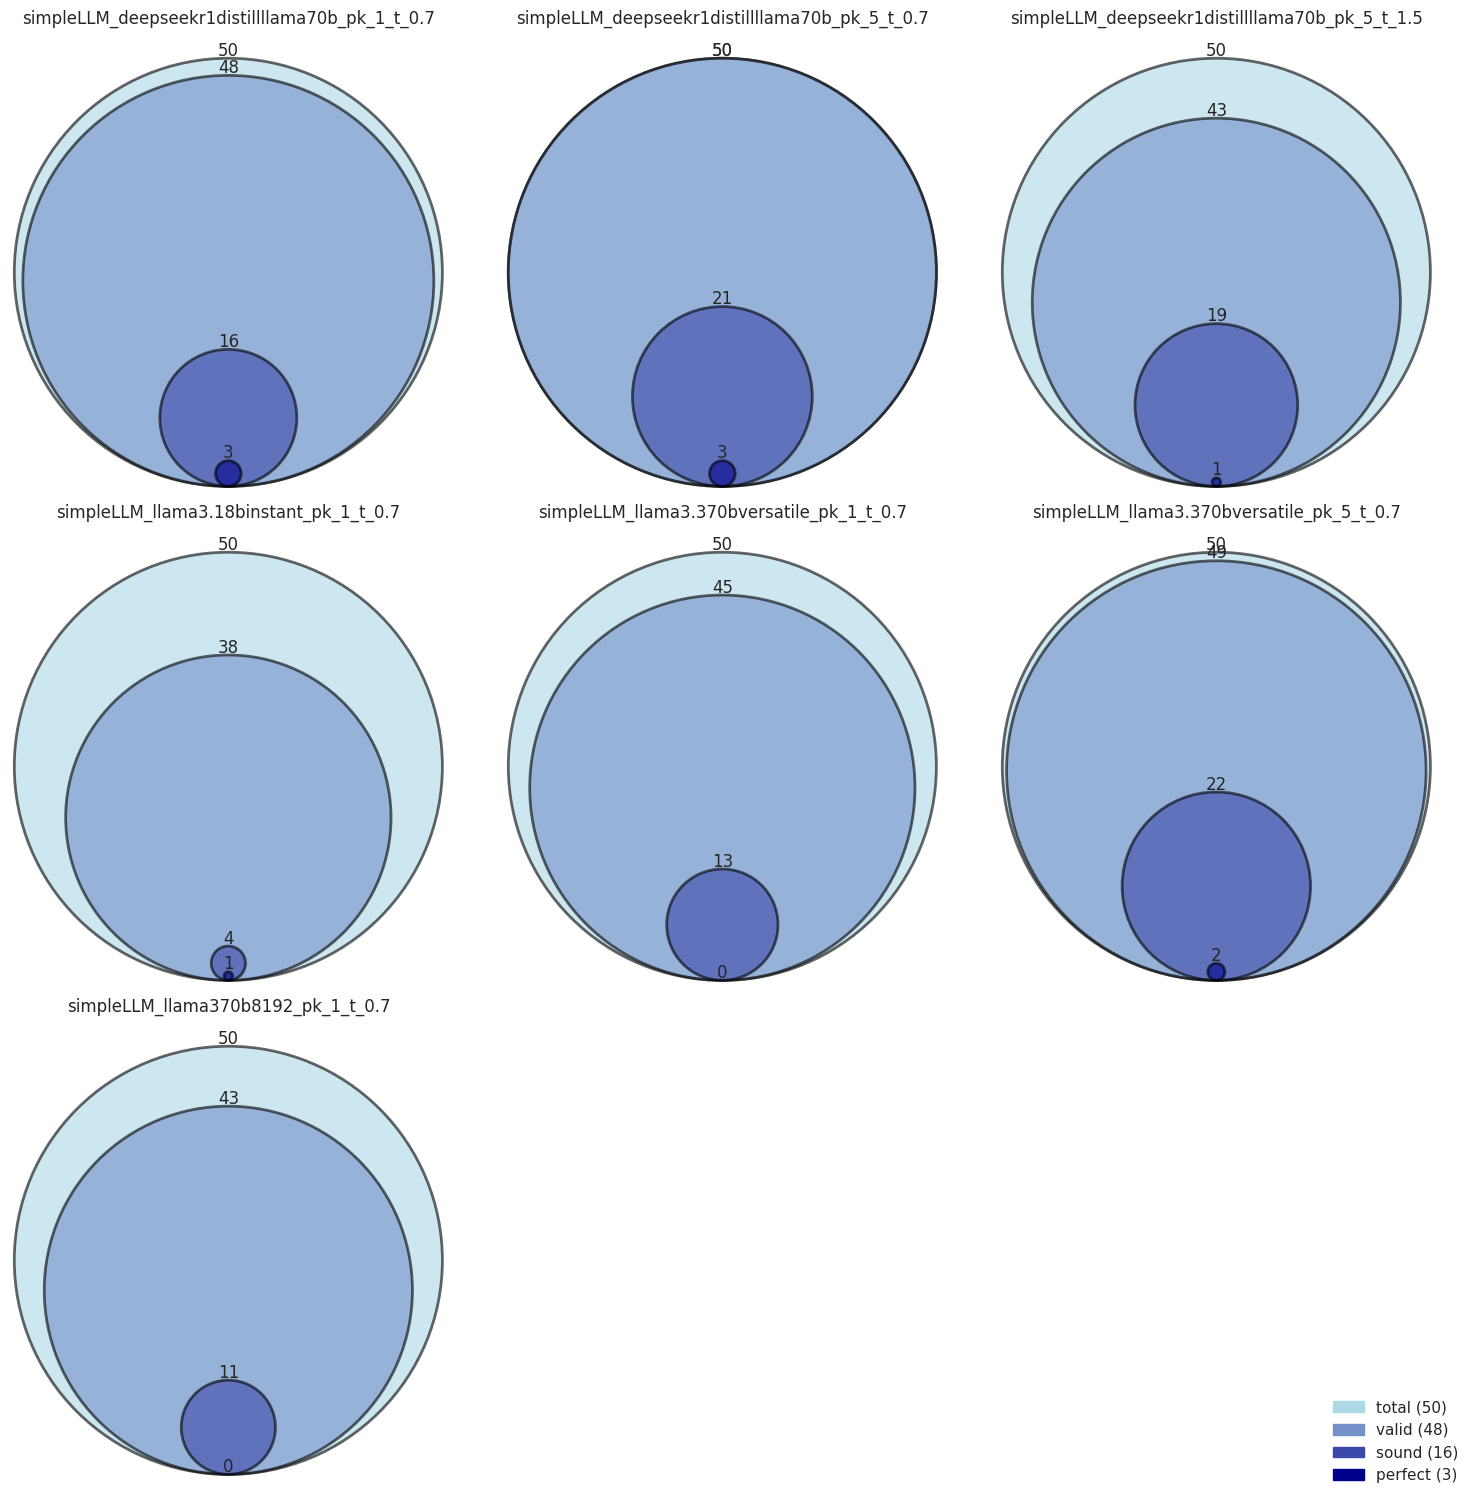

In [15]:
plot_nested_circles_subplot(classed_dataset[["config","total", "valid", "sound", "perfect"]])


## All metrics

/home/creux/miniconda3/envs/varbench/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 88.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/creux/miniconda3/envs/varbench/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 78.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/creux/miniconda3/envs/varbench/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/creux/miniconda3/envs/varbench/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 64.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/creux/

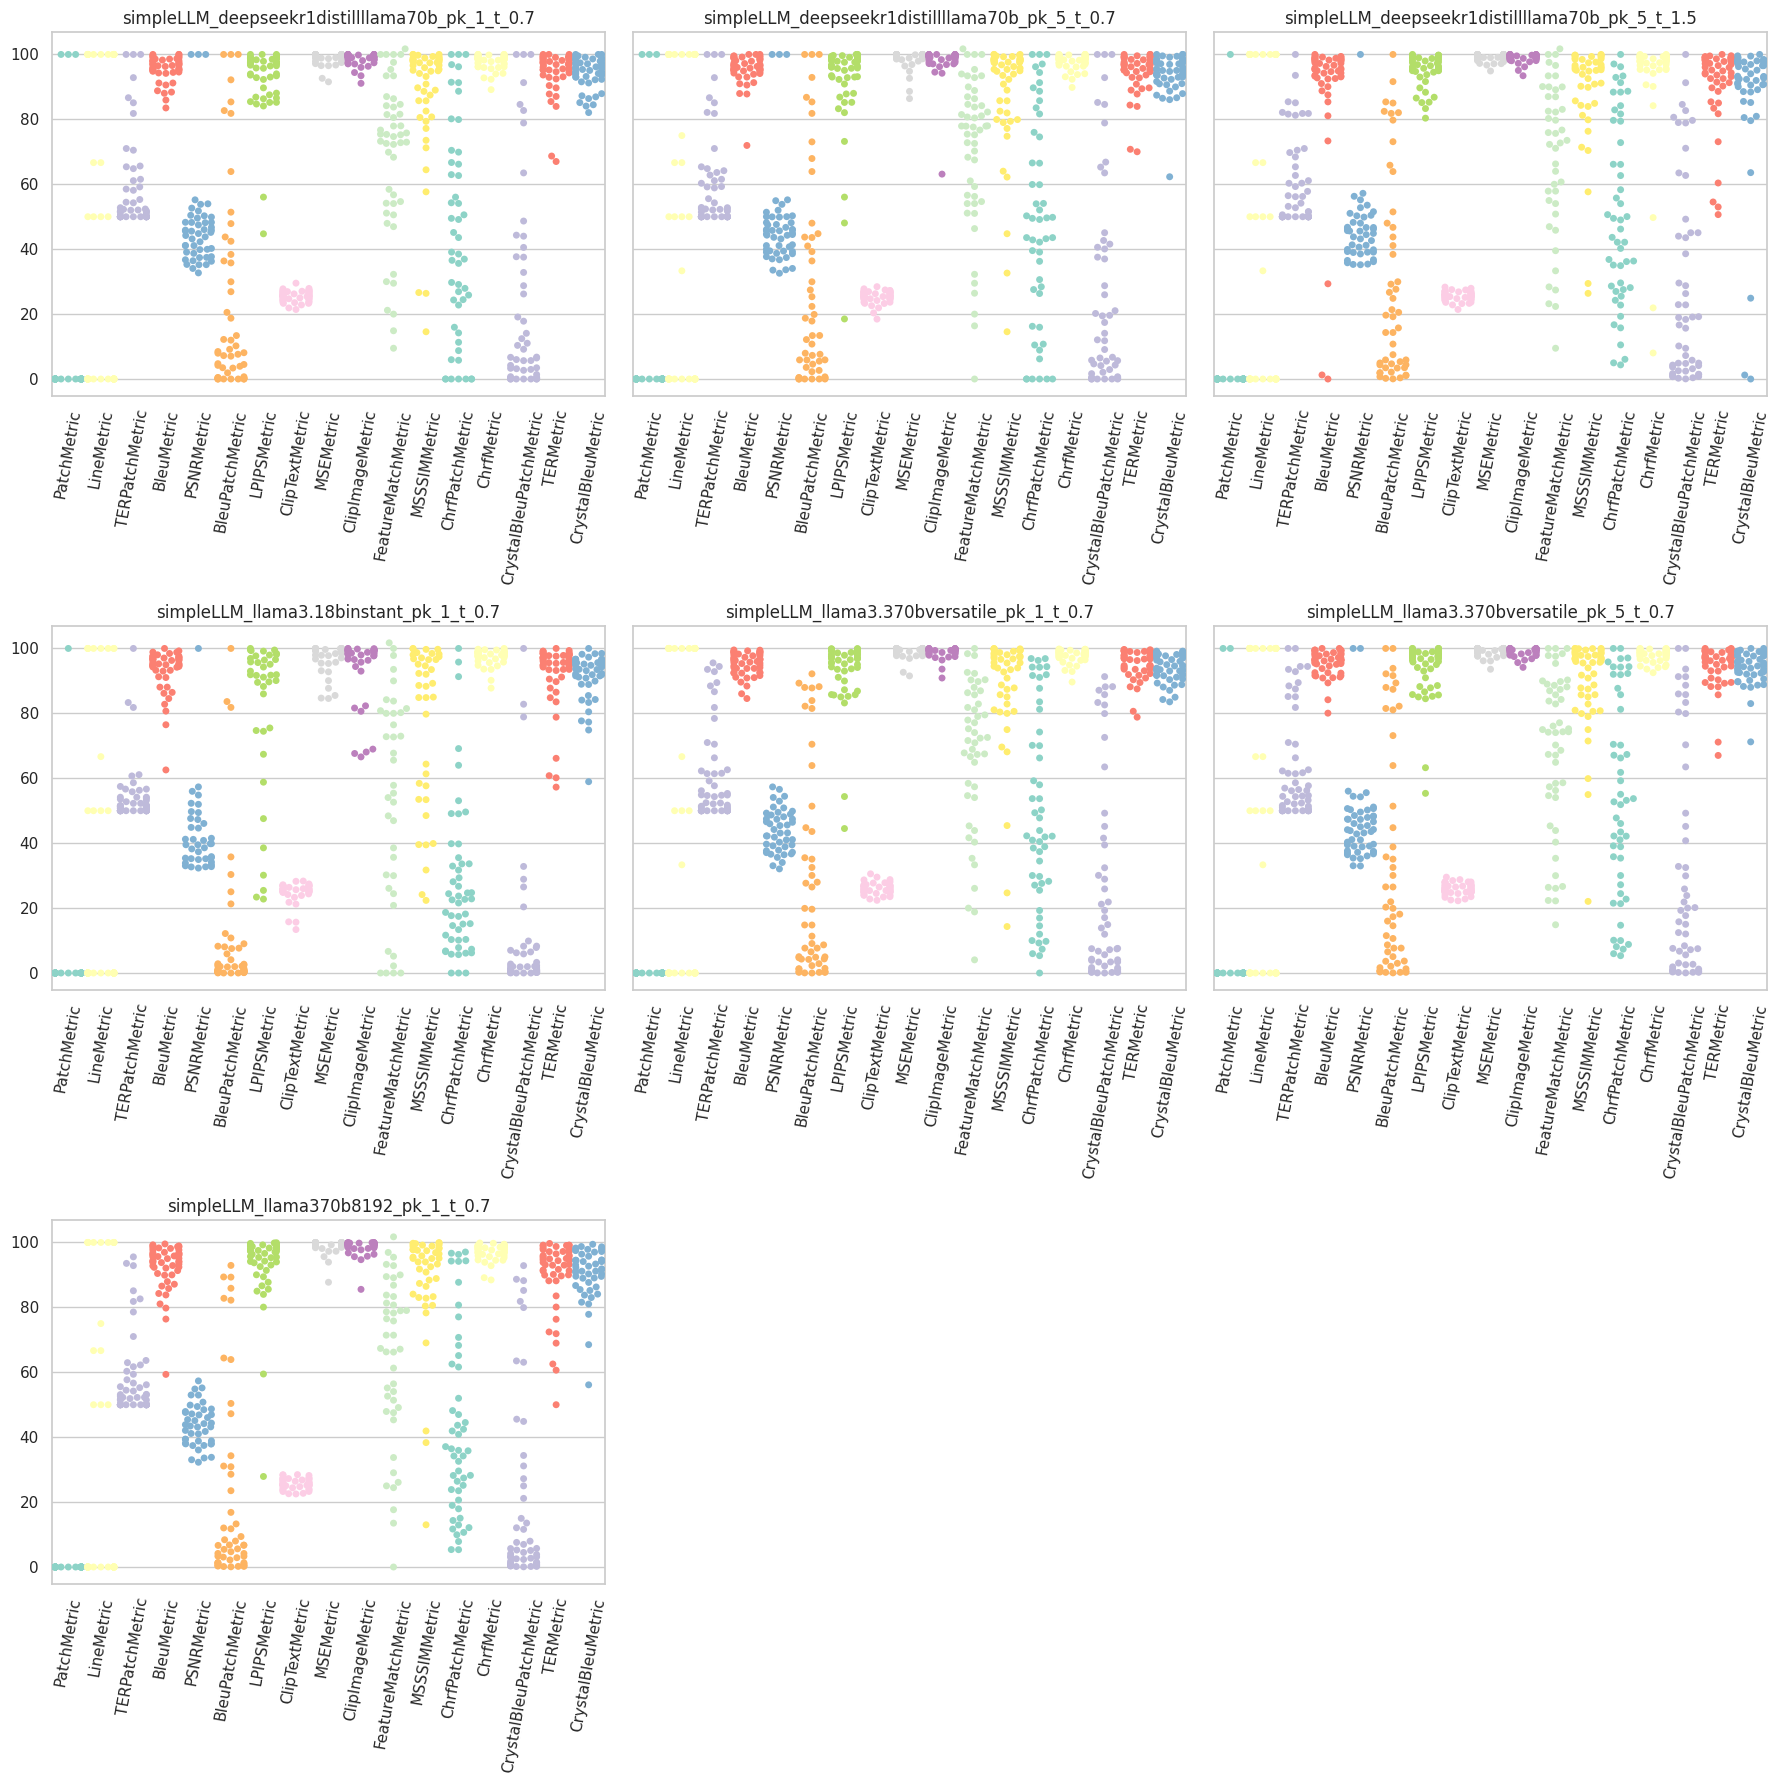

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_theme(style="whitegrid")

# Get unique configuration values
configs = filtered_df["config"].unique().tolist()

# Determine grid size
cols = 3
rows = (len(configs) // cols) + (len(configs) % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows), sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, config_name in enumerate(configs):
    sns.swarmplot(
        data=filtered_df[filtered_df['config'] == config_name], 
        ax=axes[i], 
        palette="Set3"
    )
    axes[i].set_title(f'{config_name}')
    axes[i].tick_params(axis='x', rotation=80)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(result_path, "violin_by_difficulty.png"), dpi=300, bbox_inches="tight")
plt.show()


In [17]:
filtered_df.dtypes

PatchMetric               float64
LineMetric                float64
TERPatchMetric            float64
BleuMetric                float64
PSNRMetric                float64
BleuPatchMetric           float64
LPIPSMetric               float64
ClipTextMetric            float64
MSEMetric                 float64
ClipImageMetric           float64
FeatureMatchMetric        float64
MSSSIMMetric              float64
ChrfPatchMetric           float64
ChrfMetric                float64
CrystalBleuPatchMetric    float64
TERMetric                 float64
CrystalBleuMetric         float64
id                         object
config                     object
difficulty                 object
dtype: object

In [20]:
filtered_df["config"] = pd.Categorical(
    filtered_df["config"], categories=configs, ordered=True
)

def get_compiling_score(row):
    row["valid"] = (not row.isnull().any())*100
    return row

filtered_valid = filtered_df.apply(get_compiling_score,axis=1)

averages = (
    filtered_valid.drop(["difficulty", "id"], axis=1)
    .groupby("config", observed=True)
    .mean()
    .reset_index()
)


averages.to_csv(os.path.join(result_path, "avg_by_config.csv"))


def apply_title_reduction(row):
    row["model"] = row["config"].split("_")[1]
    row["k"] = row["config"].split("_")[3]
    row["temp."] = row["config"].split("_")[5]

    return row

averages = averages.apply(apply_title_reduction, axis=1)
averages = averages.drop("config", axis=1)
for col in averages.columns:
    averages = averages.rename(columns={col: col.removesuffix("Metric")})

averages = averages[
    ["model", "k", "temp."]
    + list(set(averages.columns.to_list()) - set(["model", "k", "temp."]))
]

# averages = averages.round(1)
averages.to_latex(os.path.join(result_path, "avg_by_config.tex"), float_format="%.1f",index=False)



df_base = averages[['model', 'k', 'temp.']]

# List of metric subsets and filenames
metrics = [
    (['ChrfPatch', 'BleuPatch', 'CrystalBleuPatch', 'TERPatch'], "avg_by_config_patchtext.tex", True),
    (['LPIPS', 'MSSSIM', 'PSNR', 'ClipImage', 'ClipText', 'FeatureMatch',"MSE"], "avg_by_config_image.tex", True),
    (['Chrf', 'Bleu', 'CrystalBleu', 'TER'], "avg_by_config_full_text.tex", True),
    (['Line', 'Patch', 'valid'], "avg_by_config_patch_line.tex", True)
]

# Generate LaTeX files with resize for patch-based metrics
for cols, filename, apply_resize in metrics:
    df = df_base.join(averages[cols])
    path = os.path.join(result_path, filename)
    df.to_latex(path, float_format="%.1f", index=False)
    
    if apply_resize:  # Ensure resizebox is added correctly
        with open(path, 'r') as f:
            content = f.read()
        with open(path, 'w') as f:
            f.write(f"\\resizebox{{\\columnwidth}}{{!}}{{\n{content}\n}}")

In [21]:
filtered_df['config'] = pd.Categorical(filtered_df['config'], categories=configs, ordered=True)
averages = filtered_df.drop(["difficulty","id"],axis=1).groupby('config',observed=True).median()
averages.to_csv(os.path.join(result_path,"med_by_config.csv"))

averages

,PatchMetric,LineMetric,TERPatchMetric,BleuMetric,PSNRMetric,BleuPatchMetric,LPIPSMetric,ClipTextMetric,MSEMetric,ClipImageMetric,FeatureMatchMetric,MSSSIMMetric,ChrfPatchMetric,ChrfMetric,CrystalBleuPatchMetric,TERMetric,CrystalBleuMetric
config,,,,,,,,,,,,,,,,,
simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,0.0,0.0,51.892857,96.625275,44.990246,8.285279,96.610401,25.591466,99.675064,99.456112,74.973160,95.268536,38.801376,98.688534,6.716932,97.235386,95.218842
simpleLLM_deepseekr1distillllama70b_pk_5_t_0.7,0.0,50.0,52.409988,96.155910,44.796194,13.395387,96.582283,25.568837,99.752186,99.462086,77.769276,96.013504,49.324219,98.542561,13.080785,96.390053,94.914108
simpleLLM_deepseekr1distillllama70b_pk_5_t_1.5,0.0,50.0,52.984634,95.534275,44.856487,19.428803,96.192665,25.500870,99.641136,99.386337,73.529411,95.288261,47.605715,98.251354,18.662125,96.307575,93.249077
simpleLLM_llama3.18binstant_pk_1_t_0.7,0.0,0.0,51.388889,95.191605,39.681490,1.617397,91.831501,25.715508,99.326729,98.436115,56.618366,88.924805,22.616692,98.306614,1.266220,95.777653,94.372723
simpleLLM_llama3.370bversatile_pk_1_t_0.7,0.0,0.0,54.517664,96.148502,43.175064,10.220786,96.540611,25.891090,99.671272,99.464615,72.368423,95.517990,42.213858,98.306469,9.769201,96.819698,93.830627
simpleLLM_llama3.370bversatile_pk_5_t_0.7,0.0,50.0,56.201923,96.438332,44.155724,19.024516,97.138779,25.934027,99.716270,99.583069,74.324326,95.976860,52.311293,98.397667,18.485823,97.179108,94.810703
simpleLLM_llama370b8192_pk_1_t_0.7,0.0,0.0,52.452154,94.279785,43.434155,6.692929,96.344452,25.421940,99.678169,99.320236,67.346939,95.045212,35.875208,97.834713,5.163807,94.448395,92.094791
